# Neutrino direction reconstruction using events from a fixed source and Kotera Max flux


### Apr 15, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
import pyrex.custom.ara as ara
import corner
import itertools

Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 20
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.lines as mlines


In [3]:
# viewSigmaArr = np.array([1,5,10])
# LaunchSigmaArr = np.array([1,5,10])
# polSigmaArr = np.array([1,3,6,10])

viewSigmaArr = np.array([10])
LaunchSigmaArr = np.array([1])
polSigmaArr = np.array([10, 20, 30])

polSigma = 6
LaunchSigma = 0
viewSigma = 0

In [4]:
def nuDirReco(polVec,propVec,viewAng, noiseSigma, viewsigma):
    propVec = -propVec
    noiseSigma = np.radians(noiseSigma)#Convert to radians
    noise = np.random.normal(0,noiseSigma,1)[0]
    Psi = np.arctan2(polVec[1],polVec[0])+noise
    Omega = np.arccos(polVec[2])+noise
    polVec = SphericalToCartesian(Psi,Omega)
    noiseView = np.random.normal(0,np.radians(viewSigma),1)[0]

    recoDir = np.sin(viewAng+noiseView)*polVec-np.cos(viewAng+noiseView)*propVec
    return recoDir

def SphericalToCartesian(phi, theta):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)

    return np.array([x,y,z])

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol
chAngle = 55.8 #Cherenkov angle in ice

DeltaPol = 10.000000, DeltaLaunch = 1.000000m DeltaView = 10.000000
DeltaPol = 20.000000, DeltaLaunch = 1.000000m DeltaView = 10.000000
DeltaPol = 30.000000, DeltaLaunch = 1.000000m DeltaView = 10.000000


<Figure size 432x288 with 0 Axes>

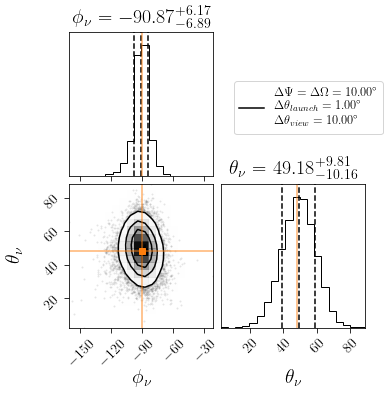

<Figure size 432x288 with 0 Axes>

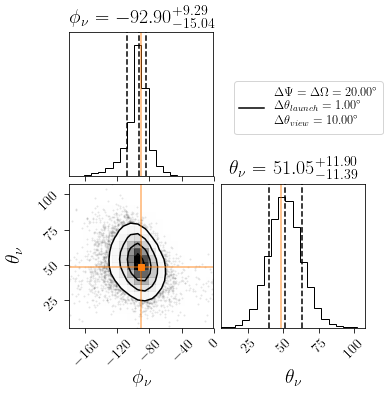

<Figure size 432x288 with 0 Axes>

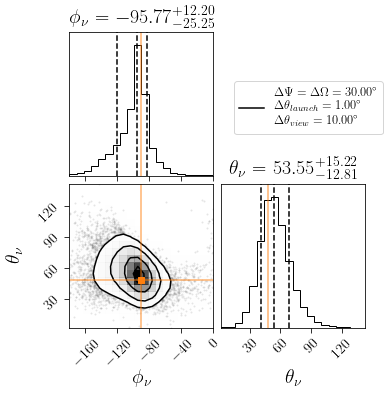

In [9]:
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/1E18FixedNnu/"):#Loop over desired directory
        if (filename.startswith("1E18")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/1E18FixedNnu/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data) 
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
# recoNu = recoNu.loc[abs(recoNu.maxV)>1]
# recoNu = recoNu.loc[abs(recoNu.maxV)<1350]
# recoNu = recoNu.loc[abs(recoNu.maxH)>1]
# recoNu = recoNu.loc[abs(recoNu.maxH)<1350]
# recoNu = recoNu.loc[recoNu.theta_reco>=np.pi/2]
recoNu = recoNu.loc[recoNu.weight<1]
recoNu["SNR_V"] = abs(recoNu.maxV)/recoNu.rmsV
recoNu["SNR_H"] = abs(recoNu.maxH)/recoNu.rmsH
# recoNu = recoNu.loc[abs(recoNu.SNR_H-5)<1]
recoNu = recoNu.loc[recoNu.SNR_H>=3]
recoNu = recoNu.loc[recoNu.SNR_V>=3]

for polSigma, LaunchSigma, viewSigma in list(itertools.product(polSigmaArr, LaunchSigmaArr, viewSigmaArr)):
# for polSigma in viewSigmaArr: 
    array2 = []
    R_True = []
    R_Reco = []
    propVec = []
    dot = []
    nnu_Reco = []
    rec_angle = []
    for i in recoNu.itertuples(): 
        thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
        phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
        if(i.powerH==0 or i.powerV==0):
            R_Reco.append(np.nan)
            R_True.append(np.nan)
            array2.append(np.nan)
            dot.append(np.nan)
            nnu_Reco.append(np.nan)
            rec_angle.append(np.nan)
            continue
        R_Reco.append(np.sqrt(i.powerH/i.powerV))
    #     R_Reco.append(abs(i.peak_H/i.peak_V))
        R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
        R_True.append(R)
    #     array2.append(util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R)))
        array2.append(i.PolTrue)

    #     PolTrue
        phi_launch = np.arctan2(i.dirProp[1],i.dirProp[0])
        theta_launch = np.pi-i.launch_ang
        noiseLaunch = np.random.normal(0,np.radians(LaunchSigma),1)[0]
        launchVec = -1*SphericalToCartesian(phi_launch+noiseLaunch,theta_launch+noiseLaunch)
        propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
        polVecSrc = rotatePolVector(launchVec,i.dirProp,i.PolTrue)
        nnu_Reco.append(nuDirReco(-polVecSrc,launchVec,i.view_ang,polSigma,viewSigma))

        dot.append(np.dot(propVec,i.PolTrue))
        rec_angle.append(np.arccos(i.dirProp[2]))
#     recoNu["PolReco2"] = array2
    recoNu["nnu_Reco"] = nnu_Reco
#     recoNu["rec_angle"] = rec_angle

#     recoNu["R_True"] = R_True
#     recoNu["R_Reco"] = R_Reco
#     recoNu["dotProd"] = dot
    recoNu = recoNu.dropna()

#     Px_true = np.array([element[0] for element in recoNu.PolTrue])
#     Py_true = np.array([element[1] for element in recoNu.PolTrue])
#     Pz_true = np.array([element[2] for element in recoNu.PolTrue])

#     Px_reco = np.array([element[0] for element in recoNu.PolReco2])
#     Py_reco = np.array([element[1] for element in recoNu.PolReco2])
#     Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


    nnuX_true = np.array([element[0] for element in recoNu.nnu])
    nnuY_true = np.array([element[1] for element in recoNu.nnu])
    nnuZ_true = np.array([element[2] for element in recoNu.nnu])

    nnuX_reco = np.array([element[0] for element in recoNu.nnu_Reco])
    nnuY_reco = np.array([element[1] for element in recoNu.nnu_Reco])
    nnuZ_reco = np.array([element[2] for element in recoNu.nnu_Reco])

    thetaNnu_true = np.degrees(np.arccos((nnuZ_true)))
    thetaNnu_reco = np.degrees(np.arccos((-nnuZ_reco)))
    phiNnu_true = np.degrees(np.arctan((nnuY_true)/(nnuX_true)))
    phiNnu_reco = np.degrees(np.arctan((nnuY_reco)/(nnuX_reco)))

    recoNu["thetaNnu_reco"] = thetaNnu_reco
    recoNu["phiNnu_reco"] = phiNnu_reco
    recoNu["thetaNnu_true"] = thetaNnu_true
    recoNu["phiNnu_true"] = phiNnu_true
#     recoNu["delta"] = thetaNnu_reco-thetaNnu_true
#     recoNu["deltaPhi"] = phiNnu_reco-phiNnu_true

    recoNu = recoNu.dropna()

    noise_Th = np.random.normal(0,6,len(recoNu.phiNnu_reco))
    noise_Ph = np.random.normal(0,6,len(recoNu.phiNnu_reco))

    nnuPhi = (recoNu.phiNnu_reco)
    nnuTheta = (recoNu.thetaNnu_reco)#+noise_Th
    plt.figure()
#     plt.hist2d(nnuPhi,nnuTheta, bins=100, weights=recoNu.weight);
#     plt.xlim(-10,10)
    print("DeltaPol = %f, DeltaLaunch = %fm DeltaView = %f"%(polSigma,LaunchSigma,viewSigma))
    x=nnuPhi-90
    # y=np.cos(np.radians(nnuTheta))
    y = nnuTheta

    data = np.vstack([x,y]).T


    # Plot it.
    figure = corner.corner(data, labels=[r"$\phi_\nu$", r"$\theta_\nu$"],
                           quantiles=[0.16, 0.5, 0.84],
                           show_titles=True,smooth=True, weights=recoNu.weight, plot_contours=True)
    corner.overplot_lines(figure, [-90,((180-recoNu.thetaNnu_true.unique()[0]))], color="C1",ls = "-",alpha = 0.6, label = "T")
    corner.overplot_points(figure, np.array([-90,((180-recoNu.thetaNnu_true.unique()[0]))])[None], color="C1", marker="s")
    black_line = mlines.Line2D([], [], color='k', label= "$\Delta\Psi = \Delta\Omega = %0.2f^\circ$ \n $\Delta\\theta_{launch} = %0.2f^\circ$ \n $\Delta\\theta_{view} = %0.2f^\circ$"%(polSigma,LaunchSigma,viewSigma))
    plt.legend(handles=[black_line],  bbox_to_anchor=(0.05, 1.3), fontsize = 12.5)
#     plt.tight_layout()
    plt.savefig(my_path_plots+"/NuDirReco/Corner_dPol_%0.1f_dLaunch_%0.1f_dView_%0.1f.png"%(polSigma,LaunchSigma,viewSigma), dpi=200)
#     plt.scatter(recoNu.phiNnu_true,recoNu.thetaNnu_true-recoNu.thetaNnu_true,s=100,c="red",marker="*",label ="True source")
#     x=nnuPhi
#     y=np.cos(np.radians(nnuTheta))
#     # plt.ylim(50,125)
#     qs = corner.quantile(x, q = [0.16,0.5,0.84])
#     qsy = corner.quantile(y, q = [0.16,0.5,0.84])

#     print("DeltaPol = %f, DeltaLaunch = %fm DeltaView = %f"%(polSigma,LaunchSigma,viewSigma))
#     print("%0.1f,%0.1f,%0.1f,%0.3f_{%0.3f}^{+%0.3f},%0.3f_{%0.3f}^{+%0.3f}"%(polSigma,LaunchSigma,viewSigma,qs[1],-qs[1]+qs[0],-qs[1]+qs[2],qsy[1],-qsy[1]+qsy[0],-qsy[1]+qsy[2]))
#     print()

In [ ]:
plt.figure(figsize=(7,5))
plt.hist2d(nnuPhi,nnuTheta,norm=mpl.colors.LogNorm(), bins =100);
plt.colorbar(label="Events [weighted]")
plt.scatter(recoNu.phiNnu_true,180-recoNu.thetaNnu_true,s=200,c="red",marker="*",label ="True source")
# plt.ylim(48,49)
# plt.xlim(-1,1)
plt.grid()
plt.legend()
plt.xlabel(r"$\phi_\nu$")
plt.ylabel(r"$\theta_\nu$")
plt.tight_layout()
# plt.savefig(my_path_plots+"/NuDirReco/NnuRecoVsTrue.pdf", dpi=200)

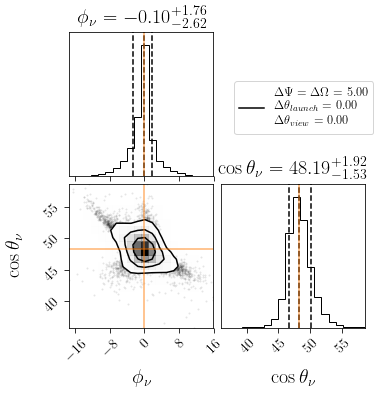

In [94]:
# fig = plt.figure(figsize=(10,6))
x=nnuPhi
# y=np.cos(np.radians(nnuTheta))
y = nnuTheta

data = np.vstack([x,y]).T


# Plot it.
figure = corner.corner(data, labels=[r"$\phi_\nu$", r"$\cos\theta_\nu$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,smooth=True, weights=recoNu.weight, plot_contours=True)
black_line = mlines.Line2D([], [], color='k', label= "$\Delta\Psi = \Delta\Omega$ = %0.2f \n $\Delta\\theta_{launch}$ = %0.2f\n $\Delta\\theta_{view}$ = %0.2f"%(polSigma,LaunchSigma,viewSigma))


corner.overplot_lines(figure, [0,((180-recoNu.thetaNnu_true.unique()[0]))], color="C1",ls = "-",alpha = 0.6)
corner.overplot_points(figure, np.array([0,np.cos(np.radians(180-recoNu.thetaNnu_true.unique()[0]))])[None], color="C1", marker="s")
# plt.title()
# plt.savefig(my_path_plots+"/NuDirReco/KDE_Fixed_recoNnu_1E18_cornerPlot.png", dpi=200)
plt.legend(handles=[black_line],  bbox_to_anchor=(0.05, 1.3), fontsize = 12.5)
plt.savefig(my_path_plots+"/NuDirReco/test.pdf")


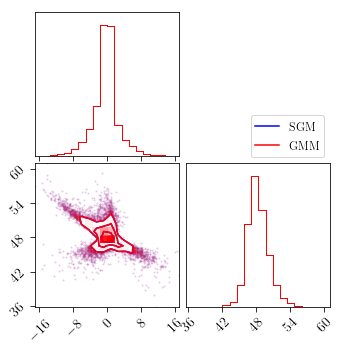

In [42]:
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='SGM')
red_line = mlines.Line2D([], [], color='red', label='GMM')
fig = corner.corner(data, color = 'b')
corner.corner(data, color = 'r', fig=fig)




In [81]:
x.median()

-9.678160642350948

In [17]:
ndim, nsamples = 2, 50000
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape([4 * nsamples // 5, ndim])
mean = 4*np.random.rand(ndim)
data2 = (mean[None, :] + np.random.randn(ndim * nsamples // 5).reshape([nsamples // 5, ndim]))
samples = np.vstack([data1, data2])


In [23]:
value2 = np.mean(samples, axis=0)
value2

array([0.13312684, 0.5341988 ])

In [26]:
np.array([0,np.cos(np.radians(180-recoNu.thetaNnu_true.unique()[0]))])[None]

array([[0.        , 0.66627602]])